## CE-like background: third pass

Use processor template on full dataset 

Dataset: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root`

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

A bit awkard but I'm using my dev version of pyutils 

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist

import sys
sys.path.append("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils")

from pyprocess import Processor, Skeleton
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector
from cut_manager import CutManager
from analyse import Analyse

# Create Processor 

In [2]:
# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True # Use remote file via mdh
        self.location = "disk" # File location
        self.max_workers = 150 # Limit the number of worker threads
        self.verbosity = 1     # Set verbosity 

        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(verbosity=0)
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!

    

In [3]:
# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
cosmic_processor = CosmicProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads
results = cosmic_processor.execute()

# You can now analyse the results

[Skeleton] ✅ Template initialised
[CosmicProcessor] Initialised
[CosmicProcessor] Starting analysis
[pyutils] Setting environment variables for this process...
[pyutils] ✅ Environment variables set
[pyprocess] ✅ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] ✅ Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] Starting processing on 817 files with 150 workers


Processing: 100%|██████████████████████████████| 817/817 [16:46<00:00,  1.23s/file, successful=817, failed=0]  

[pyprocess] ✅ Returning 817 results
[CosmicProcessor] ✅ Analysis complete


In [7]:

# Helper to convert the cut stats into a list 
def get_stats_list(results):
    # One line solution
    #  return [result["cut_stats"] for result in results if "cut_stats" in result]
    # Readable solution 
    stats = [] 
    for result in results: 
        if "cut_stats" in result: 
            stats.append(result["cut_stats"])
    return stats

stats = get_stats_list(results)

cut_manager = CutManager()

combined_stats = cut_manager.combine_cut_stats(stats)
cut_manager.print_cut_stats(stats=combined_stats, active_only=False)


[pyselect] Cut Info:
--------------------------------------------------------------------------------------------------------------
Cut                  Active     Events Passing       Absolute Frac. [%]   Relative Frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              N/A        5754129              100.00               100.00               No selection applied          
is_truth_electron    1          2319356              40.31                40.31                Track parents are electrons (truth PID)
is_reco_electron     1          2136407              37.13                92.11                Tracks are assumed to be electrons (trk)
is_downstream        1          1524458              26.49                71.36                Downstream tracks only (p_z > 0 through tracker)
has_hits             1          1293380              22.48                84.84          

In [5]:
print(results[0]["histograms"])

{'Wide range': Hist(
  Regular(250, 0, 250, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 39252.0 (39733.0 with flow), 'Signal region': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 314.0}


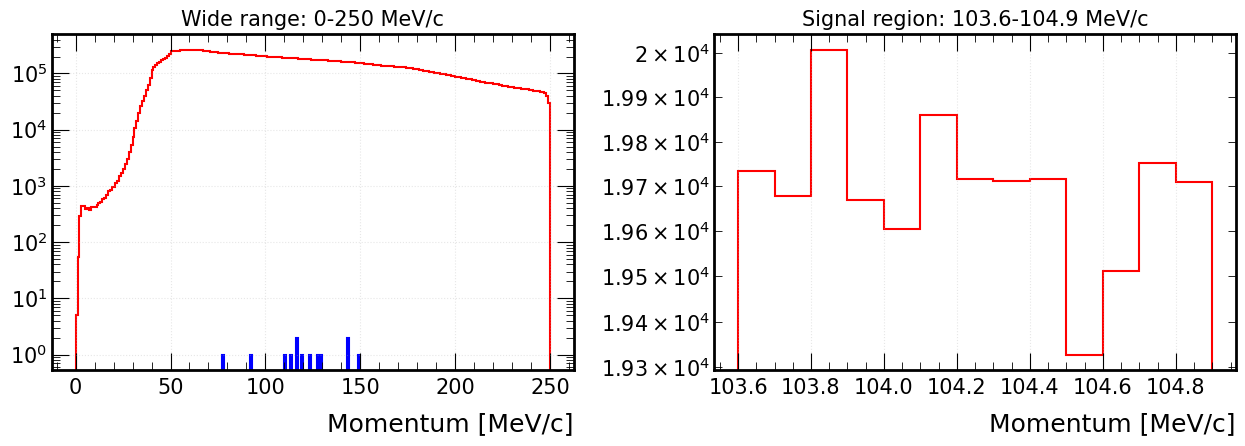

In [8]:
def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj
    
    return combined_hists

# Usage example:
combined_histograms = combine_histograms(results)

# Now you can plot them
plt.style.use("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils/mu2e.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# Plot wide range in first subplot
if 'Wide range' in combined_histograms:
    h_wide = combined_histograms['Wide range']
    h_wide.plot1d(overlay='selection', ax=axes[0])
    axes[0].set_title("Wide range: 0-250 MeV/c")
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)

# Plot signal region in second subplot
if 'Signal region' in combined_histograms:
    h_signal = combined_histograms['Signal region']
    h_signal.plot1d(overlay='selection', ax=axes[1])
    axes[1].set_title("Signal region: 103.6-104.9 MeV/c")
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel("")  # Remove duplicate y-label

plt.tight_layout()
plt.savefig("../img/h1_ana_2_mom.png", dpi=300)
plt.show()

In [9]:
results = {} 

In [11]:
print(combined_histograms)

{'Wide range': Hist(
  Regular(250, 0, 250, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 32056969.0 (32456192.0 with flow), 'Signal region': Hist(
  Regular(13, 103.6, 104.9, name='momentum', label='Momentum [MeV/c]'),
  StrCategory(['All events', 'CE-like events'], name='selection', label='Selection'),
  storage=Double()) # Sum: 256003.0 (256008.0 with flow)}
